<center><h1>Sample Work: CNN for CIFAR10 in Keras</h1></center>

This notebook consists of a Convolutional Neural Network written in Keras, trained on the CIFAR10 dataset.  I'll add some basic information at each step to cover all the salient points of the model/dataset/process. 


<center><h3>The Dataset</h3></center>

**_CIFAR10_** is a subset of the Tiny Images dataset containing 10 classes of images labeled images.  All images are 32 x 32 x 3 (meaning the image is in color, as opposed to black and white). There are a total of 60000 images in the dataset, meaning 6000 images per class. This is considered a harder image classification challenge than an introductory dataset such as MNIST because of the increased dimensionality that comes with 3 color channels and a slightly larger size.  


<center><h3>Tools Used</h3></center>

I chose to build this in **_Keras_** because the Keras API makes it incredibly easy to build prototypes.  With Keras, we get all of the benefits of Tensorflow under the hood, but without the boilerplate and overhead of pure Tensorflow (As of TF 1.5, Eager Execution is now available as a feature--I suspect that as this gains traction, complaints about Tensorflow boilerplate and setup overhead will become a thing of the past).  Keras contains great open-source implementations of all the layers needed to solve this problem, which allows us to define the architecture of our CNN with only one or two lines per layer.  

As an added benefit, Keras and Tensorflow both include _CIFAR10_ as one of their pre-packaged datasets for benchmarking model performance, so getting our data is also easy.  Aside from Keras, the only other tool used is Matplotlib, which is only used once for visualizing what an instance of our dataset actually looks like. 


<center><h3>Model Architecture</h3></center>

For this model, I chose to use a Convolutional Neural Network.  Here's a little bit about each layer used in the model, and what they are used for:


**_Convolutional Layers_**--Convolutional layers are the workhorse of CNNs, which explains the name. Convolutional Neural Networks are the considered the classic approach to image classification.  Although it's technically possible to build an image classifier using only Dense layers, a traditional Deep Neural Network would take orders of magnitude more data without the benefits of the feature maps created by the Convolutional Layers.  The main benefit of convolutional layers is that they reduce the dimensionality of of the data while mostly preserving the important information.  In this model, I use 4 Convolutional layers, with a MaxPooling2d layer after every 2 Conv2D layers.  

**_MaxPooling Layers_**--Pooling Layers are generally always used after Convolutional Layers to further reduce dimensionality.  MaxPooling is generally used, but AvgPooling is an option.  This layer looks at the feature map output by the layer before it in 2 x 2 blocks, and replaces the 2 x 2 block with the highest value contained within the block.  For instance, a MaxPooling2D layer would replace the 2x2 window `[[10, 7],[-4, 3]]` with the value `10`.  

**_Dense_**-- Dense layers are the bread and butter of Neural Networks.  These are just regular fully-connected layers, where the inputs for every neuron are the outputs from every neuron in the previous layer, along with a vector of weights corresponding to how heavily the neuron weights each output from the neuron that sent it.  In practice, these are just vectora of weights which correspond to a vector of outputs, to make the math simpler.  The neuron computes the dot product of the weight vector and output vector, adds a bias (this is randomly initialized and learned, just like the weights), and then feeds this value (usually denoted as _z_) through the chosen activation function.  The output of the activation function is then passed as input to every neuron in the following layer.

**_Activation_**-- This adds an activation function to feed the data through.  In computer vision, **_Rectified Linear Units (ReLU)_** are--by far--the most effective activation functions. ReLU outputs 0 for any negative value, but leaves any non-negative values alone.  See the graph below for a visual explanation.  


In the last layer, we use a **_Softmax_** activation function.  This function outputs a vector the shape of our labels, with each value in the vector corresponding to the percentage chance the model gives the data of being the corresponding class at that label.  The model then classifies the data as the class in the softmax output with the highest probability value.  Importantly, the sum of all values in a vector output by a softmax function will always be 1.  
<br>
<center>Example Softmax Output: `[0.02, 0.0017, 0.96, ..... 0.001]`</center>

<center>Example Label Mappings: `["Dog", "Truck", "Airplane",....... "Bird"]`</center>

**_Flatten_**: This one is simple--it's just Keras's verison of `numpy.reshape`.  This reshapes n-dimensional arrays to a vector.  This is necessary when moving from Conv2D layers, which expect 2-dimensional arrays as inputs, to Dense layers, which expect 1-dimension vectors as inputs.  As a concrete example, a Flatten layer given a 28 x 28 array as input would output a vector of the shape (784, 1).  

**_Dropout_**: Dropout layers are an effective form of regularization used in Deep Learning to prevent overfitting.  During training, the dropout layer "turns off" neurons in the previous layer, with the percentage chance of a neuron turning off being a tuneable hyperparameter passed in when the layer is created.  In this model, I've set a 25% dropout chance for neurons after the MaxPooling2D layers, and a 50% dropout chance after the Dense layers.  For a good intuition behind why dropout is effective, picture a sports team where one player is a superstar, and the coach's only objective is in winning. If the coach always relies on the superstar to do all the work, the other players (neurons) won't get much practice, and so won't learn to become better.  With dropout, there's a 50% chance the superstar neurons are turned off, giving the other neurons more practice (and more opportunities to make mistakes, which means more weight correction during the back propagation step).  Dropout layers are only used during the training step--they are turned off during testing.  

<center><h1>Walking Through the Code</h1></center>

We'll start by importing everything that we'll be using. 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten
from keras.layers import MaxPooling2D, Activation

Using TensorFlow backend.
/Users/michaelkane/anaconda3/envs/MS-ML-P3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


Next, we'll **declare important constants** such as the number of classes, batch size, etc.  We'll also create our callback which allows us to use Tensorboard to inspect all the logs from training our model.  

In the cell below, we'll import the data and split it into training and testing sets.  

In [2]:
# Declare hyperparameters and Constants
NUM_CLASSES = 10
EPOCHS = 5
NUM_PREDICTIONS = 10
BATCH_SIZE = 128
tf_callback = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)


In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

After that, we'll **normalize our image data**.  Since we're working with images, we don't need to use the normal methods for normalizing data. Since all pixels in an image can only be a value between 0 and 255, we'll just divide everything by 255.  We'll also convert our data from integers to floats.  

In [4]:
# Prepare images
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.

Next, we'll  **one-hot encode our labels**.  This means we'll turn every label into a sparse vector where all values are zero, except at the index corresponding to the correct label.  For instance, if the indexes of our labels mapped to `['dog', 'cat', 'truck']` and the first image in the dataset is of a cat, then we could expect the one-hot encoded label for the first image to look like `[0, 1, 0]`. 

Below that, I've taken the optional step of displaying a random image from the dataset just to see what we're actually working with.  

In [8]:
# Convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

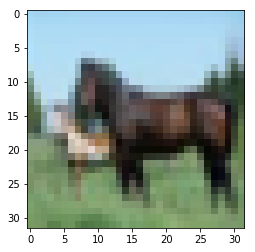

In [11]:
#Let's peek at a sample image to see what one looks like:
plt.imshow(X_train[12])

Next, we **build the model layer by layer**. `Sequential()` objects are the base models in Keras, which we then add layers to.  The Convolutional layers learn 32 image filters, with a window size of 3 x 3.  `padding=same` tells the model that the feature maps output by the convolutional layers should be the same dimensionality as the input. This is accomplished by padding the image with extra pixels with values of 0.  

To declare the size of the input layer, we just grab it from `X_train.shape`.  However, we don't include the first element, because that number corresponds to how many images are in our training set, not the shape of each image.  This means that we're telling the model to create an input layer for data of shape `(32, 32, 3)`--32 pixels high by 32 pixels wide, with 3 color channels (red, green, and blue). 

Once we've finished adding all the layers we want to our model object, we then compile it, and (optionally, but recommended) inspect a summary of what we've built.  At the bottom of the summary, we can see that this model has 1,411,242 different trainable parameters--these are the weights and biases that the model will initialize with random values to start, but will learn the correct values for during back propagation.  

In [6]:
# Build the network
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES,  activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

Finally, we **fit the model**. During this step, we pass it our training data, as well as the values we previously declared for batch size, number of epochs, etc.  We can also save ourselves some time by passing it the validation data (X_test and y_test) at this step as well.  Finally, we pass in the Tensorboard callback we set above as an optional value for `callbacks`, so that the model will write logs for us that we can inspect in Tensorboard.  

In [7]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
         validation_data=(X_test, y_test), shuffle=True, callbacks=[tf_callback])

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 158s 3ms/step - loss: 1.8952 - acc: 0.2847 - val_loss: 1.4341 - val_acc: 0.4742

After 5 epochs, we can see that the model has an accuracy score on the validation set 70.69%.  The model is clearly not done learning.  With a solid Nvidia GPU or access to a p2.xlarge instance on Amazon EC2, I would probably run this with at least 100 epochs to see where the model converges.  However, in the instance of keepings things fast, free, and still runnable on computers without access to a solid GPU, I've artifically capped the epochs at 5.  

The next steps for this model would be tuning the hyperparameters.  The first questions I would likely explore would be things such as:

--What effect does a larger or smaller learning rate have on model convergence?
--What are the trade offs between run time and learning based on larger batch sizes?
--How does a wider or deeper model architecture compare to this one in terms of run time and overall performance?

If you have any further questions about my implementation of this model, I'm happy to answer them.  Please email me at _guido.vanrawesome@gmail.com._

--Mike Kane